In [109]:
import numpy as np
from matplotlib import pyplot as plt

In [110]:
def normalizar_ponto(ponto, media, desvio_padrao):
  normal = ((ponto - media)/desvio_padrao)

  return normal

In [111]:
def desnormalizar_ponto(ponto, media, desvio_padrao):
  desnormal = ((ponto*desvio_padrao) + media)

  return desnormal

In [112]:
def media_e_desvio_padrao(dataset):
  media = np.mean(dataset, axis=0, keepdims = True)
  desvio_padrao = np.std(dataset, axis=0, keepdims = True)

  return media, desvio_padrao

In [113]:
def normalizar(dataset):
  x_data = dataset[:, :-1]
  y_data = dataset[:, -1]

  x_media, x_desvio_padrao = media_e_desvio_padrao(x_data)
  y_media, y_desvio_padrao = media_e_desvio_padrao(y_data)

  # normalizando
  x_data = ((x_data - x_media)/x_desvio_padrao)
  y_data = ((y_data - y_media)/y_desvio_padrao)

  return x_data, x_media, x_desvio_padrao, y_data, y_media, y_desvio_padrao

In [114]:
def kernel_rbf(x1, x2, amp, w):
  if x1.ndim == 1:
    x1 = x1[:, None]

  soma_ponderada = (np.sum(w * ((x1-x2) ** 2), axis = 1))
  resultado = amp * np.exp(-0.5 * soma_ponderada)

  return resultado

In [115]:
def GP(x, y):
  pontos = x.shape[0]
  amp = np.var(y)

  w = 1 / np.apply_along_axis(np.var, arr = x, axis = 0)
  k = np.zeros((pontos, pontos))

  for i in range(pontos):
    for j in range(pontos):
      k[i,j] = kernel_rbf(x[i], x[j], amp, w)

  return amp, 0.02 * amp, w, k

In [124]:
def predicao_gaussian_process(x_pred, x, y, amp, amp_y, w, k):
  pontos = x.shape[0]
  a = np.apply_along_axis(kernel_rbf, arr = x_pred, axis = 1, x2 = x, amp = amp, w = w)
  b = k + (amp_y * np.eye(pontos))
  c = np.linalg.solve(b, a.T)

  media = c @ y
  vari = kernel_rbf(x_pred, x_pred, amp, w) - np.diag(a @ b.reshape((pontos, -1)))

  return media, vari

In [117]:
with open('/content/drive/MyDrive/topicos avançados em ML/gp_data_train.csv', 'r', encoding = 'utf-8') as f:
  treino = np.genfromtxt(f, dtype = float, delimiter = ',')

In [118]:
with open('/content/drive/MyDrive/topicos avançados em ML/gp_data_test.csv', 'r', encoding = 'utf-8') as f:
  teste = np.genfromtxt(f, dtype = float, delimiter = ',')

In [119]:
treino_x, media_x, desvio_padrao_x, treino_y, media_y, desvio_padrao_y = normalizar(treino)

In [120]:
amp, amp_y, w, k = GP(treino_x, treino_y)

In [121]:
media_treino_n, vari_treino = predicao_gaussian_process(treino_x, treino_x, treino_y, amp, amp_y, w, k)
desvio_padrao_treino_n = np.sqrt(vari_treino)

media_treino = desnormalizar_ponto(media_treino_n, media_y, desvio_padrao_y)
desvio_padrao_treino = desnormalizar_ponto(desvio_padrao_treino_n, media_y, desvio_padrao_y)
treino_vari = desvio_padrao_treino ** 2

y_treino = treino[:, -1]

RMSE = np.sqrt(np.mean((media_treino - y_treino) ** 2))
NLPD = 0.5 * np.log(2 * np.pi) + 0.5 * np.mean(np.log(treino_vari) + ((y_treino - media_treino) ** 2) / treino_vari)

print("Treino: ")
print("Valor do RMSE: ", RMSE)
print("Valor do NLPD: ", NLPD)

Treino: 
Valor do RMSE:  0.23325261690053598
Valor do NLPD:  3.4606017543253675


In [122]:
x_teste = teste[:, :-1]
y_teste = teste[:, -1]

x_teste_n = normalizar_ponto(x_teste, media_x, desvio_padrao_x)
media_teste_n, teste_vari = predicao_gaussian_process(x_teste_n, treino_x, treino_y, amp, amp_y, w, k)
desvio_padrao_teste_n = np.sqrt(teste_vari)

media_teste = desnormalizar_ponto(media_teste_n, media_y, desvio_padrao_y)
desvio_padrao_teste = desnormalizar_ponto(desvio_padrao_teste_n, media_y, desvio_padrao_y)
teste_vari = desvio_padrao_teste ** 2

RMSE = np.sqrt(np.mean((media_teste - y_teste)**2))
NLPD = 0.5 * np.log(2 * np.pi) + 0.5 * np.mean(np.log(teste_vari) + ((y_teste - media_teste) ** 2) / teste_vari)

print("Teste: ")
print("Valor do RMSE: ", RMSE)
print("Valor do NLPD: ", NLPD)

Teste: 
Valor do RMSE:  0.23302774079822797
Valor do NLPD:  nan


<ipython-input-122-b64b0c3cb2f6>:6: RuntimeWarning: invalid value encountered in sqrt
  desvio_padrao_teste_n = np.sqrt(teste_vari)


<ipython-input-123-ae3648aa2354>:6: RuntimeWarning: invalid value encountered in sqrt
  y_plot_desvio_padrao = desnormalizar_ponto(np.sqrt(y_plot_n_var), media_y, desvio_padrao_y)


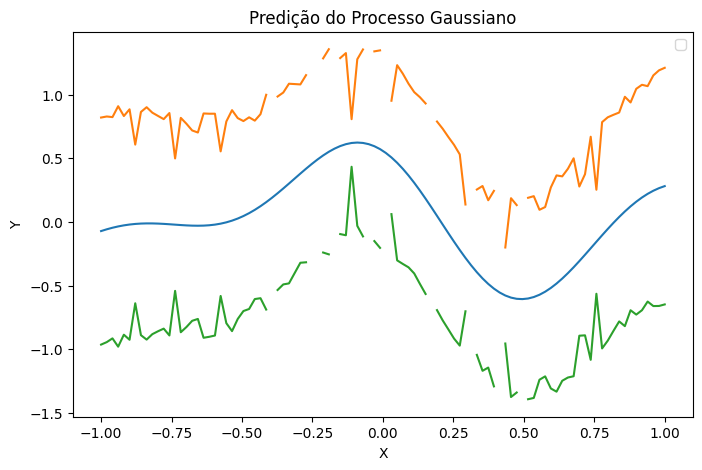

In [123]:
x_plot = np.linspace(-1, 1, 100)
x_plot_n = normalizar_ponto(x_plot, media_x, desvio_padrao_x).reshape((-1, 1))

y_plot_n_media, y_plot_n_var = predicao_gaussian_process(x_plot_n, treino_x, treino_y, amp, amp_y, w, k)
y_plot_media = desnormalizar_ponto(y_plot_n_media, media_y, desvio_padrao_y)
y_plot_desvio_padrao = desnormalizar_ponto(np.sqrt(y_plot_n_var), media_y, desvio_padrao_y)

plt.figure(figsize=(8, 5))
plt.plot(x_plot, y_plot_media)
plt.plot(x_plot, y_plot_media + (2*y_plot_desvio_padrao))
plt.plot(x_plot, y_plot_media - (2*y_plot_desvio_padrao))
plt.title('Predição do Processo Gaussiano')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()